# Import dependencies

In [1]:
import os
import re
import math
import copy
import itertools
import collections
import matplotlib.pyplot as plt
import numpy as np

# Read and store dataset functions

In [2]:
# Document class to store email instances
class Document:
    text = ""
    word_freqs = {}
    actual_label = ""
    predicted_label = ""

    def __init__(self, text, counter, actual_label):
        self.text = text
        self.word_freqs = counter
        self.actual_label = actual_label

    def getText(self):
        return self.text

    def getWordFreqs(self):
        return self.word_freqs

    def getActualLabel(self):
        return self.actual_label

    def getPredictedLabel(self):
        return self.predicted_label

    def setPredictedLabel(self, guess_label):
        self.predicted_label = guess_label

# extract words with their frequency in text
def bagOfWords(text):
    bagsofwords = collections.Counter(re.findall(r'\w+', text))
    return dict(bagsofwords)

# Read all text files in the given directory and construct the data set D
def makeDataSet(storage_dict, directory, actual_label):
    for dir_entry in os.listdir(directory):
        dir_entry_path = os.path.join(directory, dir_entry)
        if os.path.isfile(dir_entry_path):
            with open(dir_entry_path, 'r', encoding="ansi", errors='ignore') as text_file:
                text = text_file.read()
                storage_dict.update({dir_entry_path: Document(text, bagOfWords(text), actual_label)})


# Train and Test Multinomial Naive Bayes

In [3]:
# Extracts the vocabulary of all the text in a data set
def extractVocab(data_set):
    all_text = ""
    v = []
    for x in data_set:
        all_text += data_set[x].getText()
    for y in bagOfWords(all_text):
        v.append(y)
    return v

# Training
def trainMultinomialNaiveBayes(training, priors, cond):
    v = extractVocab(training)
    n = len(training)
    for c in classes:
        n_c = 0.0
        text_c = ""
        for i in training:
            if training[i].getActualLabel() == c:
                n_c += 1
                text_c += training[i].getText()
        priors[c] = float(n_c) / float(n)
        token_freqs = bagOfWords(text_c)
        # Calculate conditional probabilities for each token and sum using laplace smoothing and log-scale
        for t in v:
            # known word case
            if t in token_freqs:
                cond.update({t + "_" + c: (float((token_freqs[t] + 1.0)) / float((len(text_c) + len(token_freqs))))})
            # unknown word case
            else:
                cond.update({t + "_" + c: (float(1.0) / float((len(text_c) + len(token_freqs))))})


# Testing. 
# Returns classification guess
def applyMultinomialNaiveBayes(data_instance, priors, cond):
    score = {}
    for c in classes:
        score[c] = math.log10(float(priors[c]))
        for t in data_instance.getWordFreqs():
            if (t + "_" + c) in cond:
                score[c] += float(math.log10(cond[t + "_" + c]))
    if score["spam"] > score["ham"]:
        return "spam"
    else:
        return "ham"


# Plot Confusion Matrix

In [4]:
#Evaluation of Model - Confusion Matrix Plot
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix'):
   
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    """
    plt.figure()
    cmap=plt.cm.Blues
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

# Make Datasets

In [5]:
# Stores emails as dictionaries. file_name : email_Document
training_set = dict()
test_set = dict()
# Define classes for dataset
# ham = 0 for not spam, spam = 1 for is spam
classes = ["ham", "spam"]

# takes directories holding the data text files as paramters
def makeDatasets(training_spam_dir, training_ham_dir, test_spam_dir, test_ham_dir):
    makeDataSet(training_set, training_spam_dir, classes[1])
    makeDataSet(training_set, training_ham_dir, classes[0])
    makeDataSet(test_set, test_spam_dir, classes[1])
    makeDataSet(test_set, test_ham_dir, classes[0])

makeDatasets('train/spam', 'train/ham', 'test/spam', 'test/ham')

# Train and Test on dataset with stopwords

===============================CLASSIFICATION PERFORMANCE REPORT WITHOUT STOPWORDS REMOVED===============================
No. of true positives: 1467
No. of true negatives: 3382
No. of false positives: 290
No. of false negatives: 33
Total documents in test set: 5172
Accuracy: 93.75483372003094
Precision 83.49459305634605
Recall: 97.8
F1-score: 90.08289837273564


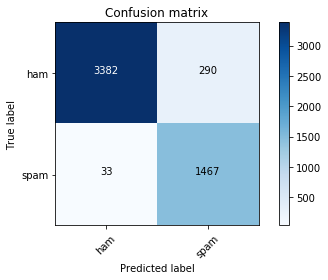

In [6]:
# Dictionary to store conditional probability and prior
conditional_probability = dict()
prior = dict()

# Train using the training data
trainMultinomialNaiveBayes(training_set, prior, conditional_probability)

# Creating Confusion matrix
# Generating True Positive, False Positive, False Negative, True Negative

true_positives = 0
true_negatives = 0
false_positives = 0
false_negatives = 0    

for i in test_set:
    test_set[i].setPredictedLabel(applyMultinomialNaiveBayes(test_set[i], prior, conditional_probability))
    if test_set[i].getPredictedLabel() == test_set[i].getActualLabel() == "spam":
        true_positives += 1
    elif test_set[i].getPredictedLabel() == test_set[i].getActualLabel() == "ham":
        true_negatives += 1
    elif test_set[i].getPredictedLabel() != test_set[i].getActualLabel() and test_set[i].getPredictedLabel() == "spam":
        false_positives += 1
    else: #test_set[i].getPredictedLabel() != test_set[i].getActualLabel() and test_set[i].getPredictedLabel() == "ham":
        false_negatives += 1

# Computing performance metrics
accuracy = float(true_positives+true_negatives) /float(true_positives+true_negatives+false_positives+false_negatives)    # (TP+TN)/(TP+TN+FP+FN)
precision = float(true_positives) /float(true_positives+false_positives)        # (TP)/(TP+FP)
recall = (true_positives) /float(true_positives+false_negatives)                # (TP)/(TP+FN)
f1_score = 2* float((precision*recall) /float(precision+recall))                # 2*(P*R/P+R)

# Printing performance metrics
print ("===============================CLASSIFICATION PERFORMANCE REPORT WITHOUT STOPWORDS REMOVED===============================")
print ("No. of true positives:", true_positives)
print ("No. of true negatives:", true_negatives)
print ("No. of false positives:", false_positives)
print ("No. of false negatives:", false_negatives)
print ("Total documents in test set:", len(test_set))
print ("Accuracy:", 100.0*accuracy)
print ("Precision", 100.0*precision)
print ("Recall:", 100.0*recall)
print ("F1-score:", 100.0*f1_score)
cm = np.array([true_negatives, false_positives, false_negatives, true_positives]).reshape(2,2)
plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix')

#  Train and Test on dataset without stopwords

===============================CLASSIFICATION PERFORMANCE REPORT WITH STOPWORDS REMOVED===============================
No. of true positives: 1467
No. of true negatives: 3390
No. of false positives: 282
No. of false negatives: 33
Total documents in test set: 5172
Accuracy: 93.90951276102089
Precision 83.87650085763293
Recall: 97.8
F1-score: 90.30470914127424


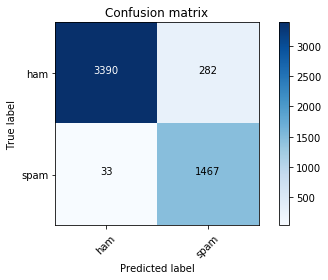

In [7]:
# Set the stop words
def setStopWords():
    stops = []
    with open('stopwords.txt', 'r') as txt:
        stops = (txt.read().splitlines())
        stops = set(stops)
    return stops

# Remove stop words from data set and store in dictionary
def removeStopWords(stops, data_set):
    filtered_data_set = copy.deepcopy(data_set)
    for i in stops:
        for j in filtered_data_set:
            if i in filtered_data_set[j].getWordFreqs():
                del filtered_data_set[j].getWordFreqs()[i]
    return filtered_data_set

# Set the stop words list
stop_words = setStopWords()

# Filtered sets without stop words
filtered_training_set = dict()
filtered_test_set = dict()

# Set up data sets without stop words
filtered_training_set = removeStopWords(stop_words, training_set)
filtered_test_set = removeStopWords(stop_words, test_set)

# Dictionary to store conditional probability and prior
filtered_conditional_probability = dict()
filtered_prior = dict()

# Train using the training data
trainMultinomialNaiveBayes(filtered_training_set, filtered_prior, filtered_conditional_probability)

# Creating Confusion matrix
# Generating True Positive, False Positive, False Negative, True Negative
true_positives = 0
true_negatives = 0
false_positives = 0
false_negatives = 0    

for i in filtered_test_set:
    filtered_test_set[i].setPredictedLabel(applyMultinomialNaiveBayes(filtered_test_set[i], filtered_prior, filtered_conditional_probability))
    if filtered_test_set[i].getPredictedLabel() == filtered_test_set[i].getActualLabel() == "spam":
        true_positives += 1
    elif filtered_test_set[i].getPredictedLabel() == filtered_test_set[i].getActualLabel() == "ham":
        true_negatives += 1
    elif filtered_test_set[i].getPredictedLabel() != filtered_test_set[i].getActualLabel() and filtered_test_set[i].getPredictedLabel() == "spam":
        false_positives += 1
    else: #filtered_test_set[i].getPredictedLabel() != filtered_test_set[i].getActualLabel() and filtered_test_set[i].getPredictedLabel() == "ham":
        false_negatives += 1

# Computing performance metrics
accuracy = float(true_positives+true_negatives) /float(true_positives+true_negatives+false_positives+false_negatives)    # (TP+TN)/(TP+TN+FP+FN)
precision = float(true_positives) /float(true_positives+false_positives)        # (TP)/(TP+FP)
recall = (true_positives) /float(true_positives+false_negatives)                # (TP)/(TP+FN)
f1_score = 2* float((precision*recall) /float(precision+recall))                # 2*(P*R/P+R)

# Printing performance metrics
print ("===============================CLASSIFICATION PERFORMANCE REPORT WITH STOPWORDS REMOVED===============================")
print ("No. of true positives:", true_positives)
print ("No. of true negatives:", true_negatives)
print ("No. of false positives:", false_positives)
print ("No. of false negatives:", false_negatives)
print ("Total documents in test set:", len(filtered_test_set))
print ("Accuracy:", 100.0*accuracy)
print ("Precision", 100.0*precision)
print ("Recall:", 100.0*recall)
print ("F1-score:", 100.0*f1_score)
cm = np.array([true_negatives, false_positives, false_negatives, true_positives]).reshape(2,2)
plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix')